$$\textbf{Machine Learning. Tarea 5: UNET}$$
$$\textit{Y. Sarahi García Gozález}$$

Esta tarea la compile localmente en mi máquina pues en colab no logré hcaerlo (se acababa la ram con los datos). Utilicé 2000 imágenes e hice un aumento de 500 imágenes sobre el conjunto de Train (mi máquina no me permitió hacer más, después de 500 moría el kernel).


<font size=4 color='mediumslateblue'>  

$\textit{Librerías}$

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
import sklearn as sk
import scipy as sp
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import read_depth as rd


In [3]:
print("Tarea realizada en MacOs. \nLas versiones de las librerías y de python utilizadas fueron:\n")
from platform import python_version
print("Python version:", python_version())
print("NumPy version:", np.__version__)
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE") 


Tarea realizada en MacOs. 
Las versiones de las librerías y de python utilizadas fueron:

Python version: 3.11.5
NumPy version: 1.23.5
Tensor Flow Version: 2.16.1
Keras Version: 3.3.3
Scikit-Learn 1.3.0
SciPy 1.11.4
GPU is available


In [4]:
len(tf.config.list_physical_devices('GPU'))

1

<font size=4 color='mediumslateblue'>  

$\textit{Prepocesamiento de los datos}$

Descargué los datos y para cargar los mapas de prfundidad utilicé la libreria read_depht que proporciona la página de donde obtuvimos el dataset

In [5]:
def load_data(datos_phat):
    #listas vacias para almacenar las imagenes y los mapas de profundidad
    images = []
    depth_maps = []
    #creamos un lista con los directorios que se encuentra dentro de la carpeta "datos"
    directorios = os.listdir(datos_phat)
    for directorio in directorios: #iteramos sobre éstos 

        #si dentro de "datos" se encuentra un archivo .DS_Store, lo ignoramos (esto pasa en sistema MacOs)
        if directorio=='.DS_Store':
            continue

        #guardamos ruta de directorio imagenes
        image_directorio = os.path.join(datos_phat, directorio, "image")
        #guardamos ruta de directorio mapas de profundidad
        depth_map_directorio = os.path.join(datos_phat, directorio, "groundtruth_depth")

        #creamos una lista de los archivos dentro del directorio imagenes
        image_files = os.listdir(image_directorio)
        #creamos una lista de los archivos dentro del directorio mapas d profundudad
        depth_map_files = os.listdir(depth_map_directorio)

        #iteramos sobre las listas anteriores 
        for image_file, depth_map_file in zip(image_files, depth_map_files):
            #creamos la ruta completa de la imagen actual
            image_path = os.path.join(image_directorio, image_file)
            #leemos
            image = cv2.imread(image_path)
            #ajutamo la escala
            image = cv2.resize(image,(224, 224) )

            #creamos la ruta completa del mapa actual
            depth_map_path = os.path.join(depth_map_directorio, depth_map_file)
            #leemos
            depth_map = rd.depth_read(depth_map_path)
            depth_map =  cv2.resize(depth_map, (224, 224))

            #agregmos la imagen y el mapa actuales a las listas correspondiente
            images.append(image)
            depth_maps.append(depth_map)

    return np.array(images), np.array(depth_maps)

In [6]:
#cargamos los datos usando la funcion load data
path = "/Users/ely/Documents/Maestria/segundo_semestre/cimat2023-1/machine/04_Tarea4_machine/datos"
X, y = load_data(path)


Aumentemos el numero de imagenenes en el conjunto  X y y

In [7]:

datagen = ImageDataGenerator(
    rotation_range=20,      #rotación aleatoria en grados
    width_shift_range=0.1,  #esplazamiento horizontal aleatorio
    height_shift_range=0.1, #Desplazamiento vertical aleatorio
    shear_range=0.2,        # Intensidad de la deformación de cizalla
    zoom_range=0.2,         #rango de zoom aleatorio
    horizontal_flip=True,  #Volteo horizontal aleatorio
    fill_mode='nearest'     #Modo de relleno para los píxeles fuera de los límites de la imagen original
)


batch_size = 64
num_augmented_images = 1000  # Número de imágenes a generar
num_batches = num_augmented_images // batch_size
#listas vacias para datos aumentds
X_uaumentado = []
y_uaumentado = []

for batch in range(num_batches):
    #Generamos un lote de imágenes aumentadas y etiquetas correspondientes
    augmented_data = next(datagen.flow(X, y, batch_size=batch_size, shuffle=False))
    #Extraemos las imágenesy las etiquetas 
    X_batch_augmented, y_batch_augmented = augmented_data
    #La agregamos a los conjuntos corresp.
    X_uaumentado.append(X_batch_augmented)
    y_uaumentado.append(y_batch_augmented)

# Convertimos la lista de lotes de imágenes aumentadas en un único conjunto
X_uaumentado = np.concatenate(X_uaumentado, axis=0)
y_uaumentado = np.concatenate(y_uaumentado, axis=0)



Ahora concatenamos las imágenes y mapas aumentados con los conjuntosoriginales

In [8]:
X = np.concatenate([X, X_uaumentado], axis=0)

In [9]:
y = np.concatenate([y, y_uaumentado], axis=0)

Se pide:
* Entrada: imágenes rgb+ en 224x224 pixéles
* Salida: imágenes escala de gris codificando profundidad en 224x224 pixeles

In [10]:
print("Shape of images X:", X.shape)
print("Shape of depth maps y:", y.shape)

Shape of images X: (2960, 224, 224, 3)
Shape of depth maps y: (2960, 224, 224)


In [11]:
X = X.astype('float32') / 255.0
Y = y.astype('float32') / 255.0

Dividimos en entrenamiento 80% y prueba 20%

In [12]:
#Entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2368, 224, 224, 3)
Shape of y_train: (2368, 224, 224)
Shape of X_test: (592, 224, 224, 3)
Shape of y_test: (592, 224, 224)


(-0.5, 223.5, 223.5, -0.5)

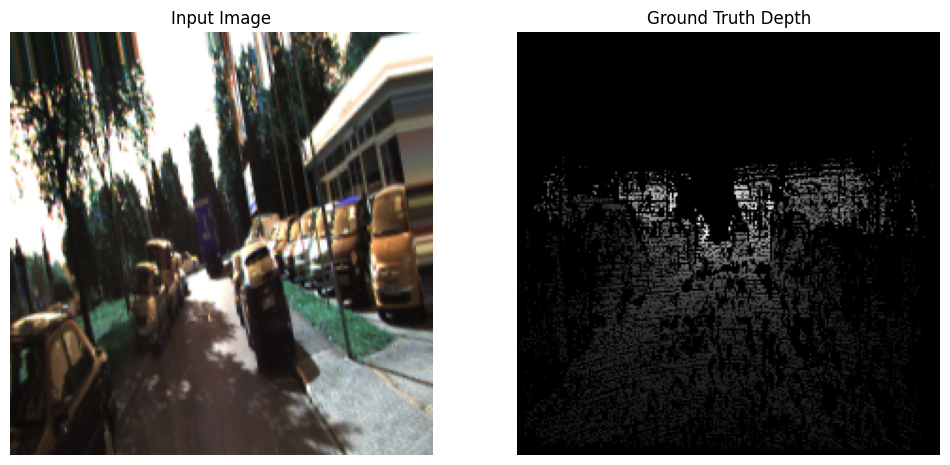

In [13]:
ejem=2300 #ejemplo imagen aumentada
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(X_train[ejem])
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(y_train[ejem], cmap='gray')
plt.title('Ground Truth Depth')
plt.axis('off')

<font size=4 color='mediumslateblue'>  

$\textit{U-NET}$

Definimos una función get_model con parámetro $\textit{trainable}$ que define si la red VGG16 va a ser entrenada con todo el modelo o se van a quedar fijos sus pesos.
En esta fucnión se concatena una capa convucional transpuesta 2D por cada bloque de la VGG16 (la ultima de las layers).

In [82]:
#https://keras.io/examples/vision/oxford_pets_image_segmentation/
def get_model(trainable):
    #ruta de los pesos de vgg16
    weights_path = '/Users/ely/Documents/pre-trained/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

    #Imágenes RGB de 224x224 pixeles para la entrada
    img_size = (224, 224, 3)  

    #  Usanos VGG16 con los pesos descargados, sólo la etapa de extración de resgos, e input de 224x224 RGB
    conv_base = VGG16(weights=weights_path, include_top=False, input_shape=img_size)
    #pesos no entrenable para que no se actualicen durante el entrenamiento del autoencoder
    conv_base.trainable = trainable

    

    x=conv_base.get_layer("block5_pool").output

    # Entry block
    x=layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x=layers.Concatenate()([x,(conv_base.get_layer("block5_conv3").output)])
    #  Block 2
    x=layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x=layers.Concatenate()([x,(conv_base.get_layer("block4_conv3").output)])
    #  Block 3
    x=layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x=layers.Concatenate()([x,(conv_base.get_layer("block3_conv3").output)])
    #  Block 4
    x=layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x=layers.Concatenate()([x,(conv_base.get_layer("block2_conv2").output)])

    outputs = layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='sigmoid')(x)

    # Define the model
    model = tf.keras.Model(inputs= conv_base.input   , outputs=outputs)

    return model



<font size=4 color='mediumslateblue'>  

$\textit{Fine-Tuning}$

In [ ]:
# Build model
unet = get_model(False)
unet.summary()

In [70]:
#Parametros para el modelo autoencoder
num_epochs = 5
lr = 0.0001
batch_size = 32

In [71]:
checkpoint_filepath = 'best_model.keras'
#callback para el mejor modelo 
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#usamos adam
optimizer = Adam(learning_rate=lr)
#compilamos
unet.compile(optimizer=optimizer, loss='mse')
#entrenamos
history = unet.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])


Epoch 1/5


2024-05-03 19:59:10.909922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 33.5534
Epoch 1: val_loss improved from inf to 34.12046, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - loss: 33.5540 - val_loss: 34.1205
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 32.9309
Epoch 2: val_loss improved from 34.12046 to 33.19532, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - loss: 32.9292 - val_loss: 33.1953
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 32.0669
Epoch 3: val_loss improved from 33.19532 to 33.14118, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - loss: 32.0725 - val_loss: 33.1412
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 31.9556
Epoch 4: val_loss improved from 33.14118 to 33.11753, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - loss: 31.9622 - val_loss: 33.1175
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 33.0913
Epoch 5: val_loss improved from 33.11753 to

In [72]:
#predicción
y_pred= unet.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 979ms/step


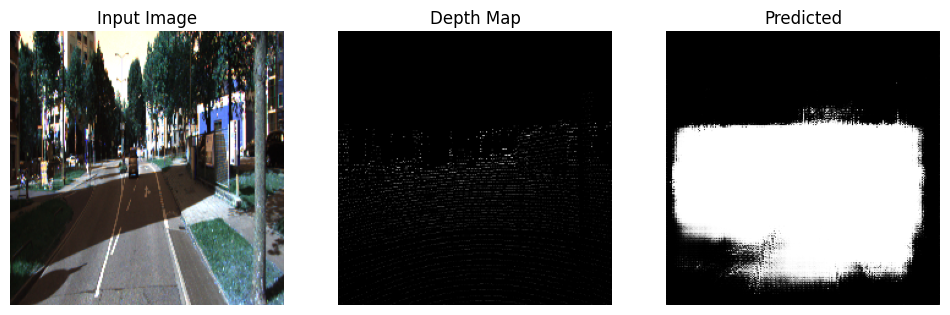

In [73]:
ejem2=142

plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(X_test[ejem2])
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_test[ejem2], cmap='gray')
plt.title('Depth Map')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_pred[ejem2], cmap='gray')
plt.title('Predicted')
plt.axis('off')

plt.show()

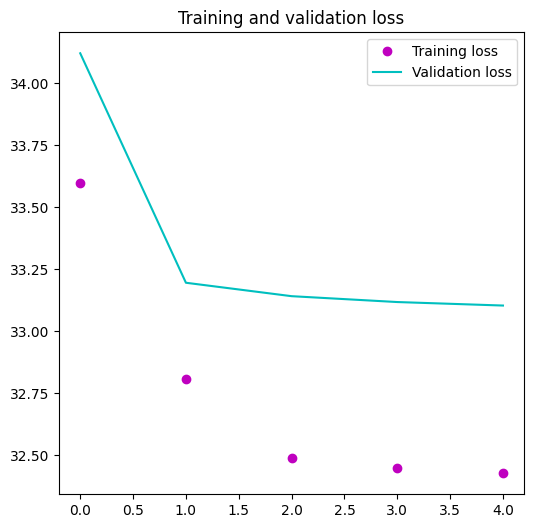

In [74]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure(figsize=(6,6))


plt.plot(epochs, loss, 'mo', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<font size=4 color='mediumslateblue'>  

$\textit{Ajuste completo}$

In [76]:
# Build model
unet_completo = get_model(True)
unet_completo.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_14[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 19,206,945 (73.27 MB)

 Trainable params: 19,206,945 (73.27 MB)

 Non-trainable params: 0 (0.00 B)

Ahora entrenamos usando todos los parámetros

In [77]:
#Parametros para el modelo autoencoder
num_epochs = 10
lr = 0.0001
batch_size = 32

In [78]:
checkpoint_filepath = 'best_model1.keras'
#callback para el mejor modelo 
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#usamos adam
optimizer = Adam(learning_rate=lr)
#compilamos
unet_completo.compile(optimizer=optimizer, loss='mse')
#entrenamos
history = unet_completo.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 33.4446
Epoch 1: val_loss improved from inf to 33.30006, saving model to best_model1.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - loss: 33.4422 - val_loss: 33.3001
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 32.8344
Epoch 2: val_loss improved from 33.30006 to 33.06978, saving model to best_model1.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 437s 6s/step - loss: 32.8293 - val_loss: 33.0698
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 32.1194
Epoch 3: val_loss improved from 33.06978 to 33.06395, saving model to best_model1.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 462s 6s/step - loss: 32.1233 - val_loss: 33.0640
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 31.5068
Epoch 4: val_loss did not improve from 33.06395
74/74 ━━━━━━━━━━━━━━━━━━━━ 484s 7s/step - loss: 31.5189 - val_loss: 33.0950
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 32.8316
Epoch 5: val_loss improved from 33.06395 to 33.05607, saving mod

In [79]:
y_pred_completo= unet_completo.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 926ms/step


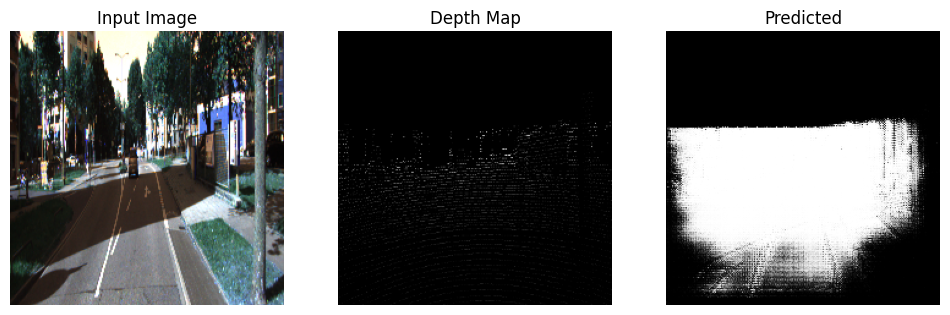

In [80]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(X_test[ejem2])
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_test[ejem2], cmap='gray')
plt.title('Depth Map')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_pred_completo[ejem2], cmap='gray')
plt.title('Predicted')
plt.axis('off')

plt.show()

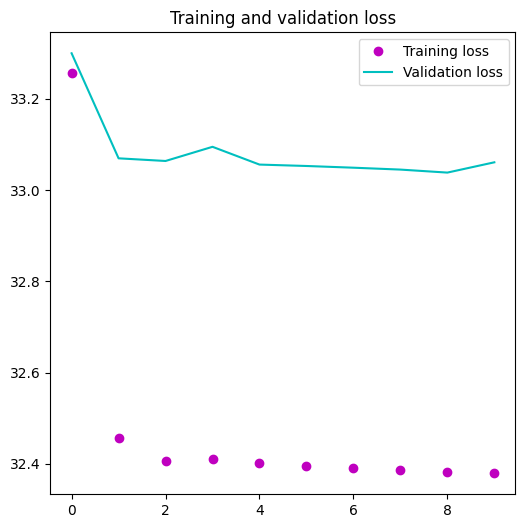

In [81]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure(figsize=(6,6))


plt.plot(epochs, loss, 'mo', label='Training loss')
plt.plot(epochs, val_loss, 'c', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()